#### Imports

In [407]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as ps

#### Preparing dataset for ML model

In [408]:
linkedin = pd.read_csv('../data/linkedin_standarized.csv')
linkedin.sample(5)

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary
298,3767591534,Data Analyst,SynergisticIT,WA,Presencial,Prácticas,Prácticas,L,96000.0
406,3772209411,Data Engineer,InvestM Technology LLC,NY,Presencial,Contrato por obra,Sin experiencia,M,108480.0
9,3628866409,Machine Learning Engineer,AeroVironment,MN,Híbrido,Jornada completa,Sin experiencia,L,307710.0
296,3767466154,Data Analyst,WayUp,CA,Presencial,Prácticas,Prácticas,M,96000.0
571,3776948509,Data Scientist,HustleWing - Side hustles for professionals,USA,En remoto,Media jornada,Algo de responsabilidad,S,NaN


In [409]:
linkedin.shape

(580, 9)

First we need to see which columns have null values.

In [410]:
linkedin.isna().sum()

job_id               0
job_title            0
company_name         0
company_state        0
remote_ratio        17
employment_type      0
experience_level     3
company_size         6
salary              72
dtype: int64

The ones with salary range in null value, are going to be the predicted ones.

In [411]:
to_predict = linkedin[linkedin['salary'].isnull()]
to_predict.shape

(72, 9)

In [412]:
linkedin = linkedin[~linkedin['salary'].isnull()]
linkedin.shape

(508, 9)

Let's save this dataframe for sql queries.

In [413]:
linkedin.to_csv('../data/linkedin_salaries_sql.csv', index=False)

Let's check again null values in order to delete those rows.

In [414]:
linkedin.isna().sum()

job_id              0
job_title           0
company_name        0
company_state       0
remote_ratio        2
employment_type     0
experience_level    3
company_size        5
salary              0
dtype: int64

In [415]:
linkedin = linkedin.dropna()
linkedin.shape

(499, 9)

##### Function to clean both datasets

In [457]:
# prepared_to_predict = to_predict[~to_predict.drop(['salary'], axis=1).isna().all(axis=1)]
prepared_to_predict = to_predict.dropna(subset=to_predict.columns.difference(['salary']), how='any')
prepared_to_predict.shape

(56, 9)

    Column 'job_title'

Classificating the job_title category with numbers.

In [417]:
linkedin.groupby('job_title')['salary'].mean().reset_index().sort_values(by='salary', ascending=False)

,job_title,salary
7,Deep Learning Engineer,195115.090909
8,Machine Learning Engineer,176279.583333
9,Research Engineer,176125.000000
1,BI Analyst,155742.333333
6,Data Scientist,139677.333333
5,Data Engineer,131093.882353
4,Data Analyst,112255.272727
0,AI Engineer,96454.166667
3,Business Analyst,96250.000000
2,BI Engineer,75000.000000


    Column 'remote_ratio'

In [418]:
linkedin['remote_ratio'].value_counts()

remote_ratio
En remoto     195
Híbrido       176
Presencial    128
Name: count, dtype: int64

    Column 'employment_type'

In [419]:
linkedin['employment_type'].value_counts()

employment_type
Jornada completa     369
Contrato por obra    100
Prácticas             30
Name: count, dtype: int64

    Column 'experience_level'

In [420]:
linkedin['experience_level'].value_counts()

experience_level
Intermedio                 254
Sin experiencia            133
Algo de responsabilidad     48
Prácticas                   45
Director                    17
Ejecutivo                    2
Name: count, dtype: int64

    Column 'company_size'

In [421]:
linkedin['company_size'].value_counts()

company_size
L    314
M    166
S     19
Name: count, dtype: int64

#### Cleaning function

In [422]:
def categorizing_dataset(dframe):
    # ------ Cleaning: group
    df = dframe.copy()

    # 1. job_title
    job_categories = {
        'Deep Learning Engineer': 10,
        'Machine Learning Engineer': 9,
        'Research Engineer': 8,
        'BI Analyst': 7,
        'Data Scientist': 6,
        'Data Engineer': 5,
        'Data Analyst': 4,
        'Business Analyst': 3,
        'AI Engineer': 2,
        'BI Engineer': 1
    }
    df["job_title"] = df.job_title.replace(job_categories)

    # 2. remote_ratio
    remote_categories = {
        'En remoto': 100,
        'Híbrido': 50,
        'Presencial': 0
    }
    df["remote_ratio"] = df.remote_ratio.replace(remote_categories)

    # 3. employment_type
    oneonehotencoder = ps.OneHotEncoder()
    df[['Jornada completa', 'Contrato por obra', 'Prácticas']] = oneonehotencoder.fit_transform(df["employment_type"].values.reshape(-1, 1)).toarray()

    # 4. experience_level
    experience_categories = {
        'Director': 3,
        'Ejecutivo': 3,
        'Algo de responsabilidad': 2,
        'Intermedio': 2,
        'Sin experiencia': 1,
        'Prácticas': 0
    }
    df["experience_level"] = df.experience_level.replace(experience_categories)

    # 5. company_size
    df[['L', 'M', 'S']] = oneonehotencoder.fit_transform(df["company_size"].values.reshape(-1, 1)).toarray()

    return df

In [423]:
prepared_linkedin = categorizing_dataset(linkedin)
prepared_linkedin.sample(5)

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary,Jornada completa,Contrato por obra,Prácticas,L,M,S
146,3759325599,5,Steneral Consulting,USA,50,Jornada completa,2,M,175000.0,0.0,1.0,0.0,0.0,1.0,0.0
523,3775841139,9,Actalent,MD,100,Jornada completa,1,L,247750.0,0.0,1.0,0.0,1.0,0.0,0.0
161,3760509927,6,Trusaic,CA,50,Jornada completa,2,M,150000.0,0.0,1.0,0.0,0.0,1.0,0.0
96,3752871763,9,Red Oak Technologies,TX,100,Contrato por obra,2,L,108480.0,1.0,0.0,0.0,1.0,0.0,0.0
415,3772689030,4,"Ryder System, Inc.",TX,50,Contrato por obra,1,L,67500.0,1.0,0.0,0.0,1.0,0.0,0.0


In [424]:
prepared_to_predict = categorizing_dataset(prepared_to_predict)
prepared_to_predict.sample()

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary,Jornada completa,Contrato por obra,Prácticas,L,M,S
235,3764783040,5,MindPal,AZ,0,Prácticas,0,M,NaN,0.0,0.0,1.0,0.0,1.0,0.0


In [425]:
prepared_to_predict.isna().sum()

job_id                0
job_title             0
company_name          0
company_state         0
remote_ratio          0
employment_type       0
experience_level      0
company_size          0
salary               56
Jornada completa      0
Contrato por obra     0
Prácticas             0
L                     0
M                     0
S                     0
dtype: int64

In [426]:
# Viz mantra
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

from sklearn import metrics

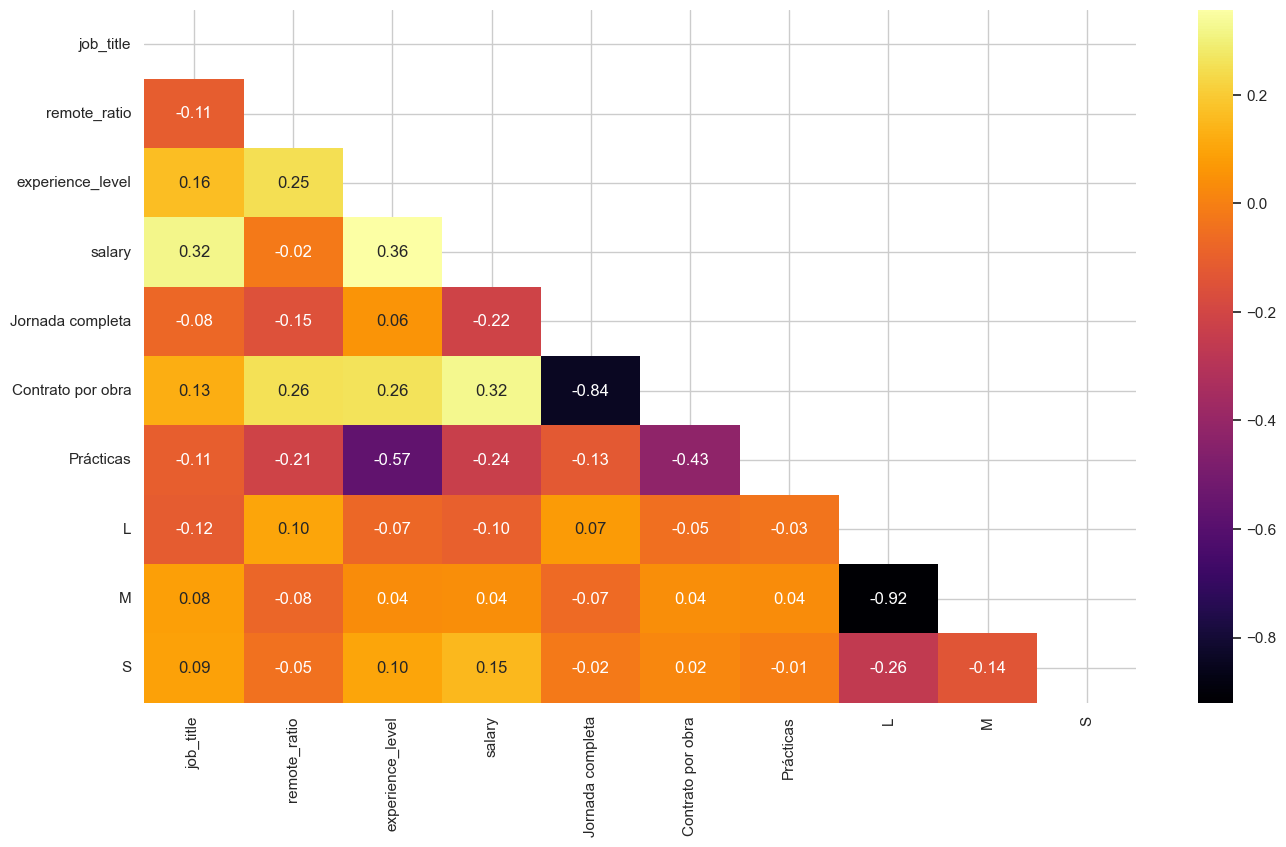

In [427]:
corr = prepared_linkedin.select_dtypes(exclude=['object']).drop(columns=['job_id']).corr()
sns.heatmap(corr, annot=True, cmap='inferno', fmt='.2f', mask=np.triu(corr));

#### Models

In [428]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [429]:
# X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary', 'min_salary', 'max_salary'])
X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary'])
y = prepared_linkedin['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [430]:
X_train.shape

(374, 10)

    LinearRegression

In [431]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [432]:
y_pred = regressor.predict(X_test)

In [433]:
metrics.r2_score(y_test, y_pred)

0.19409700379445716

    DecisionTreeRegressor

In [434]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [435]:
y_pred = regressor.predict(X_test)

In [436]:
metrics.r2_score(y_test, y_pred)

0.1151772628710166

    KNeighborsRegressor

In [437]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [438]:
y_pred = regressor.predict(X_test)

In [439]:
metrics.r2_score(y_test, y_pred)

0.41535095322147675

    GradientBoostingRegressor

In [440]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [441]:
y_pred = regressor.predict(X_test)

In [442]:
r2_grad = metrics.r2_score(y_test, y_pred)
r2_grad

0.5970859012962955

    Code to save the model

In [443]:
import pickle

# model_file = f'../models/GradientBoostingRegressor_r2_{r2_grad}.pkl'
# with open(model_file, 'wb') as f:
#     pickle.dump(regressor, f)

In [444]:
model_file = '../models/GradientBoostingRegressor_r2_0.8219972580147646.pkl'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

pred = model.predict(X_test)
# pred = model.predict(X_test.drop(columns=['min_salary', 'max_salary']))

r2_pred = metrics.r2_score(y_test, pred)
r2_pred

0.8690084309231023

    RandomForestRegressor

In [445]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [446]:
y_pred = regressor.predict(X_test)

In [447]:
r2 = metrics.r2_score(y_test, y_pred)
r2

0.6214139514094524

    Code to save the model

In [448]:
import pickle

# model_file = f'../models/RandomForestRegressor_r2_{r2}.pkl'
# with open(model_file, 'wb') as f:
#     pickle.dump(regressor, f)

In [449]:
model_file = '../models/RandomForestRegressor_r2_0.645222589224115.pkl'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

pred = model.predict(X_test)
# pred = model.predict(X_test.drop(columns=['min_salary', 'max_salary']))

r2_pred = metrics.r2_score(y_test, pred)
r2_pred

0.9069870517674925

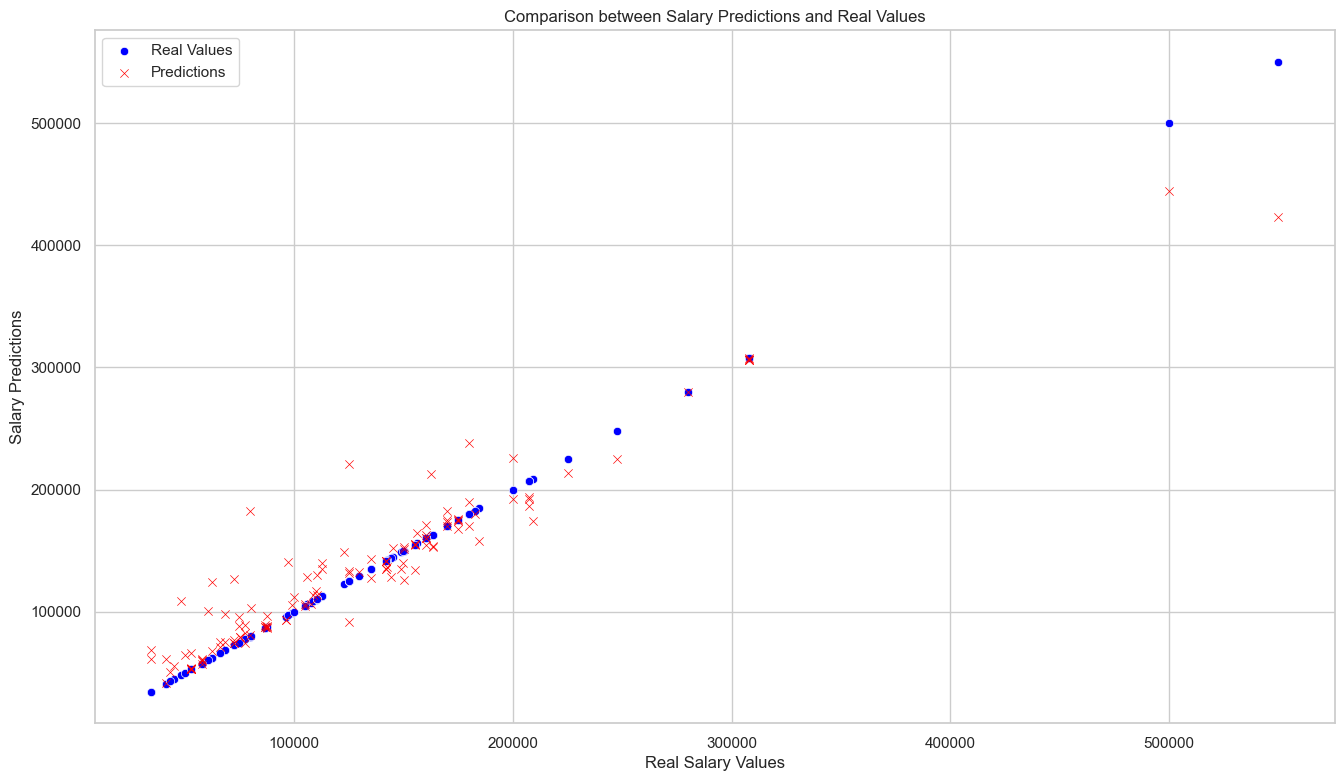

In [458]:
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Real Values', marker='o')
sns.scatterplot(x=y_test, y=pred, color='red', label='Predictions', marker='x')

plt.xlabel('Real Salary Values')
plt.ylabel('Salary Predictions')
plt.title('Comparison between Salary Predictions and Real Values')
plt.legend()
# plt.savefig(f'../figures/RFRmodel_r2_{r2_pred}.jpg')
plt.show()

#### TESTS with X_test

In [451]:
X_test_copy = X_test.copy()
X_test_copy['pred_salary'] = y_pred
X_test_copy['salary'] = y_test
X_test_copy.sample(5)

,job_id,job_title,remote_ratio,experience_level,Jornada completa,Contrato por obra,Prácticas,L,M,S,pred_salary,salary
367,3770174091,4,50,2,0.0,1.0,0.0,1.0,0.0,0.0,104714.72,60480.0
259,3766016312,9,50,2,0.0,1.0,0.0,0.0,1.0,0.0,191810.00,160000.0
3,3577492525,10,50,1,0.0,1.0,0.0,1.0,0.0,0.0,292016.10,307710.0
63,3742232441,4,50,2,0.0,1.0,0.0,0.0,1.0,0.0,117265.50,170000.0
242,3765083210,5,50,0,0.0,1.0,0.0,0.0,1.0,0.0,61278.00,52800.0


    Saving X_test and prediction to see accuracy in tableau

In [452]:
X_test_copy.to_csv('../data/tableau_csv/X_test.csv')

#### Prediction for those with null salary

In [453]:
prediction = regressor.predict(prepared_to_predict.select_dtypes(exclude=['object']).drop(columns=['salary']))

In [454]:
to_predict.sample()

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary
306,3768034086,Data Analyst,Skiltrek,CA,En remoto,Media jornada,Sin experiencia,M,NaN


In [455]:
prepared_to_predict['salary'] = prediction # Adding the predicted price
prepared_to_predict.sample(5)

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary,Jornada completa,Contrato por obra,Prácticas,L,M,S
306,3768034086,4,Skiltrek,CA,100,Media jornada,1,M,118773.68,0.0,1.0,0.0,0.0,1.0,0.0
101,3755005401,5,Get It Recruit - Real Estate,VA,50,Prácticas,0,S,89387.00,0.0,0.0,1.0,0.0,0.0,1.0
274,3766684640,5,DeRisk Technologies,MO,50,Media jornada,0,L,58356.50,0.0,1.0,0.0,1.0,0.0,0.0
572,3776952405,6,Forsyth Barnes,USA,100,Media jornada,2,M,131992.50,0.0,1.0,0.0,0.0,1.0,0.0
264,3766280936,3,Get It Recruit - Finance,CA,100,Prácticas,0,S,91750.00,0.0,0.0,1.0,0.0,0.0,1.0


In [456]:
prepared_to_predict.to_csv('../data/linkedin_predicted_sql.csv', index=False)